In [2]:
# ====================================================
# Libraries
# ====================================================
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import itertools
from tqdm.auto import tqdm
from functools import partial

from PIL import Image

import cv2
from skimage import io
import torch
from torch import nn
import os
import tqdm
from datetime import datetime
import time
import random
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
import timm
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

import sklearn
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import pydicom

from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from torch import nn

from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()   # interactive mode


IMAGE_DIR = image_dir = '/home/arti/DL/Datasets/chest_xray/train/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # cuda:0
#device = torch.device("cpu")
print(device)

hide_toggle(for_next=False)

cuda:0


In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle(for_next=False)

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    num_workers=4
    model_name='resnext50_32x4d'  # 'resnext50_32x4d'
    size=224 ###
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    T_0=10 # CosineAnnealingWarmRestarts
    epochs=10
    lr=1e-4
    min_lr=1e-6
    batch_size=4 # 32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
    print_freq=100
    smoothing=0.05
    
hide_toggle(for_next=False)

In [4]:
classes = ['NORMAL', 'PNEUMONIA']
img_names_df = []

for cls in classes:
    path_to_img = image_dir+cls
    for filename in os.listdir(path_to_img):
            img_names_df.append([cls+'/'+filename, cls])

img_names_df = pd.DataFrame(img_names_df)
img_names_df.columns = ['names', 'class']

img_names_df['label'] = img_names_df['class'].copy()
img_names_df.loc[(img_names_df['class'] == 'NORMAL'), 'label'] = 0
img_names_df.loc[(img_names_df['class'] == 'PNEUMONIA'), 'label'] = 1

#print('\nDataset:')
#print('len -', len(img_names_df))
#print('\nsample:\n',img_names_df.sample(5))
#print('\nValue counts:\n', img_names_df['label'].value_counts(), sep='')
hide_toggle(for_next=False)

In [5]:
train, test = train_test_split(img_names_df, test_size=0.2, shuffle=True, random_state=42)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
#print('\nTrain and Val shapes: ',train.shape, test.shape)
hide_toggle(for_next=False)

In [6]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['names'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = image_dir + file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()  # self.labels[idx]
        return image, label, file_name
    
    
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['names'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):    
        file_name = self.file_names[idx]
        file_path = image_dir + file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image
    
hide_toggle(for_next=False)

In [7]:

def get_transforms(*, data):
    
    if data == 'train':
        return Compose([            
            Rotate(limit=10, p=0.7), # пов-ем картинку на +- 10 гр с p=70%
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.75, 1)),#делаем приближение на число [0.75, 1], resize до 256x256 
            HorizontalFlip(p=0.5),# зеркалим
            
            OneOf([
                A.Cutout(max_h_size=15,max_w_size=15),  # вырезает вадратики 15x15
                A.CoarseDropout(max_height=25, max_width=25, min_height=10, min_width=10, fill_value=0)], p=0.5), 
                                                             
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'train_without_augment':
        return Compose([            
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.8, 1)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
hide_toggle(for_next=False)

In [8]:
def train_fn(train_loader, model, criterion, optimizer, device):    
    # switch to train mode
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)

        t_outputs = model(images) # every batch of 100 images are put as an input.
        t_loss = criterion(t_outputs, labels)
        
        # print("labels:", labels)
        # print("outputs:", t_outputs)

        optimizer.zero_grad() #setting the initial gradient to 0
        t_loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        preds = torch.max(t_outputs, 1)[1] # taking the highest value of prediction.
        # print("preds:", preds)

        running_loss += t_loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
    
    # Total Epoch loss and Acc
    epoch_loss = running_loss/len(train_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(train_loader) # accuracy per epoch
        
    return epoch_loss, epoch_acc

def valid_fn(val_loader, model, criterion, device):    
    # switch to evaluation mode
    model.eval()
    
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    with torch.no_grad(): # we do not need gradient for validation.

        for v_images, v_labels, _ in val_loader:
            v_images, v_labels = v_images.to(device), v_labels.to(device)

            val_outputs = model(v_images)
            val_loss = criterion(val_outputs, v_labels)
            
            val_preds = torch.max(val_outputs, 1)[1]
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == v_labels.data)
            
        val_epoch_loss = val_running_loss/len(val_loader)
        val_epoch_acc = val_running_corrects.float()/ len(val_loader)
    
    return val_epoch_loss, val_epoch_acc

def train_loop(train_loader, val_loader, model, criterion, optimizer, epochs, device):
    model.to(device);
    
    for epoch in range(epochs):
        print('epoch :', epoch)
        
        epoch_loss, epoch_acc = train_fn(train_loader, model, criterion, optimizer, device)
        print('training loss: {:.4f}, training acc {:.4f} '.format(epoch_loss, epoch_acc.item()/CFG.batch_size))
        
        val_epoch_loss, val_epoch_acc = valid_fn(val_loader, model, criterion, device)
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()/CFG.batch_size))
        
hide_toggle(for_next=False)

In [9]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))  # train train_without_augment
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

val_dataset = TrainDataset(test, transform=get_transforms(data='valid'))
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

print('Train:', len(train_dataset), len(train_loader))
print('Test: ', len(val_dataset), len(val_loader))

Train: 4185 1046
Test:  1047 261


torch.Size([3, 224, 224])


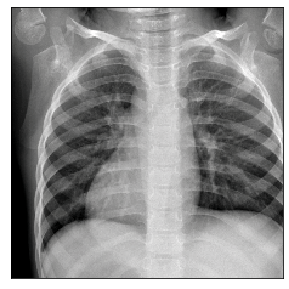

In [10]:
def plot_image(i=0):
    plt.figure(figsize=(16, 5))
    UnNormalize = transforms.Compose([ 
        transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),])
    
    image = train_dataset[i][0]
    print(image.shape)
    image = UnNormalize(image)
    image = image.numpy()
    image = np.moveaxis(image, 0, -1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.show()
    
plot_image(10)

In [23]:
class BaseConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, in_3x3, out_3x3, in_5x5, out_5x5, out_pool):
        super().__init__()
        
        self.branch1 = BaseConvBlock(in_channels, out_1x1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            BaseConvBlock(in_channels, in_3x3, kernel_size=1),
            BaseConvBlock(in_channels, out_3x3, kernel_size=3, padding=1),
        )
        
        self.branch3 = nn.Sequential(
            BaseConvBlock(in_channels, in_5x5, kernel_size=1),
            BaseConvBlock(in_channels, out_5x5, kernel_size=5, padding=2),
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BaseConvBlock(in_channels, out_pool, kernel_size=1),
        )
        
    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        
        out = torch.cat([out1, out2, out3, out4], 1)
        return out


class GoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.opening = nn.Sequential(
            BaseConvBlock(in_channels=3, out_channels=64, kernel_size=7, padding=3, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            BaseConvBlock(in_channels=64, out_channels=192, kernel_size=3, padding=1, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # In this order: in_channels, out_1x1, in_3x3, out_3x3, in_5x5, out_5x5, out_pool
        self.Inceptions_part = nn.Sequential(
            InceptionBlock(192, 64, 96, 128, 16, 32, 32),
            InceptionBlock(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            InceptionBlock(480, 192, 96, 208, 16, 48, 64),
            InceptionBlock(512, 160, 112, 224, 24, 64, 64),
            InceptionBlock(512, 128, 128, 256, 24, 64, 64),
            InceptionBlock(512, 112, 144, 288, 32, 64, 64),
            InceptionBlock(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            InceptionBlock(832, 256, 160, 320, 32, 128, 128),
            InceptionBlock(832, 384, 192, 384, 48, 128, 128),
        )
        
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1024, 2)
        
    def forward(self, x):
        x = self.opening(x)
        x = self.Inceptions_part(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout()
        x = self.fc(x)
        return out

In [24]:
model = GoogLeNet()
model.to(device);

optimizer = Adam(model.parameters(), lr=CFG.lr/10, weight_decay=CFG.weight_decay, amsgrad=False)
error = nn.CrossEntropyLoss()

In [ ]:
train_loop(train_loader, val_loader, model, error, optimizer, 5, device)